In [9]:
import numpy as np
import math
import scipy.stats
import random
import matplotlib.pyplot as plt

In [183]:
#data
price_data = abs(np.random.normal(loc = 0, scale = 1, size=1000000))
predicate_data = np.random.choice(['Coke', 'Pepsi'], 1000000, True)
data = [price_data, predicate_data]

In [184]:
#store the sum
sum_data = np.sum(data[0])
def get_sum():
    return sum_data

In [185]:
#sample+seek paper
def create_measure_biased_samples_sum(data, sample_table_size):
    sample_probabilities = []
    for i in range (len(data[0])):
        sample_probabilities.append (data[0][i])
    sample_probabilities = sample_probabilities/np.sum(sample_probabilities)
    sample_indices = np.random.choice(len(data[0]), sample_table_size, True, sample_probabilities)
    sample_data = np.zeros((sample_table_size, 2)).tolist()
    for i in range (len(sample_indices)):
        sample_data[i][0] = data[0][sample_indices[i]]
        sample_data[i][1] = data[1][sample_indices[i]]
    return sample_data

In [186]:
#create samples
samples = create_measure_biased_samples_sum (data, 1000)
a = .05
m = len(samples)
e = .1

In [188]:
#get sampling bounds
predicates = ['Pepsi', 'Coke']
counts = {'Pepsi':0, 'Coke':0}
total_count = 0
for sample in samples:
    counts[sample[1]] += 1
    total_count +=1

z = scipy.stats.norm.ppf(1-a/2)
x_l = {'Pepsi':0, 'Coke':0}
x_u = {'Pepsi':0, 'Coke':0}
for predicate in predicates:
    k_x = counts[predicate]
    T = z*math.sqrt(z**2 - 1/m + 4*k_x*(1-k_x/m)+(4*k_x/m-2)) + 1
    x_l[predicate] = (2*k_x + z**2 -T)/(2*(m+z**2))
    x_u[predicate] = (2*k_x + z**2 +T)/(2*(m+z**2))

In [189]:
#actual answer
actual_sums = {'Pepsi':0, 'Coke':0}
for i in range (len(data[0])):
    actual_sums[data[1][i]] += data[0][i]
selectivity_threshold = 1/math.sqrt(len(data[0]))


In [194]:
#direct scaling and MSE
MSE = 0
for predicate in predicates:
    proportion_estimate = counts[predicate]/total_count
    #sample+seek theorem 3
    if (len(samples)<(1/proportion_estimate)*(1/a**2)):
        print ("Potentially inaccurate approximation: too few samples for " + predicate + " selectivity")
    sum_estimate = proportion_estimate*sum_data
    MSE += (actual_sums[predicate]-sum_estimate)
    sum_lower_bound = x_l[predicate]*sum_data
    sum_upper_bound = x_u[predicate]*sum_data
    print (predicate)
    print ("sum estimate: " + str(sum_estimate))
    print ("lower bound " + str(sum_lower_bound))
    print ("upper bound " + str(sum_upper_bound))
    print()
MSE = MSE/len(predicates)
print ("MSE: " + str(MSE))

Pepsi
sum estimate: 416879.1072462624
lower bound 391798.43632324756
upper bound 441959.7781692772

Coke
sum estimate: 381868.6950041671
lower bound 356790.19194579043
upper bound 406947.1980625437

MSE: 1.367880031466484e-09


1000000

Dataset size (10000, 50)


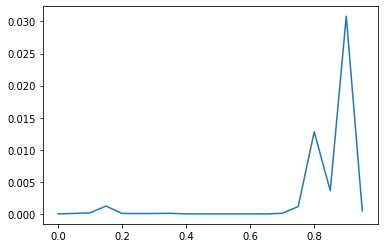

Dataset size (20000, 50)


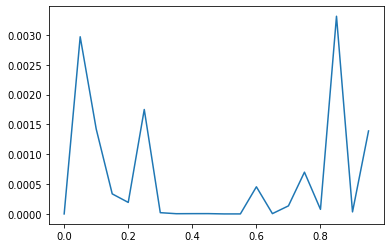

Dataset size (30000, 50)


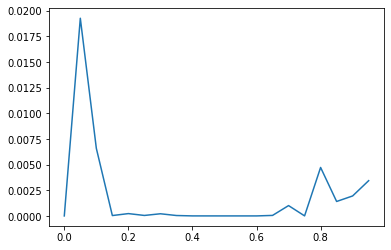

Dataset size (40000, 50)


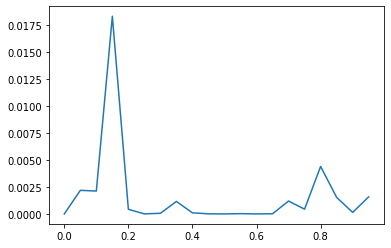

Dataset size (50000, 50)


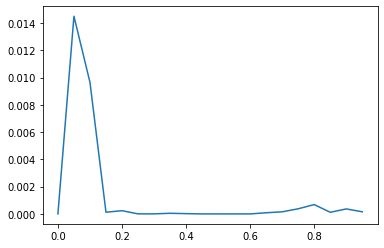

In [20]:
from tdigest import TDigest

datasets = [(10000, 50), (20000, 50), (30000, 50), (40000, 50), (50000, 50)]
quantiles = np.arange(0, 1, 0.05)# [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

def get_actual_quantile(col, quantile, data, data_size):
    return np.quantile(data, quantile)

def get_approx_quantile(col, quantile, data, data_size):
    digest = TDigest()
    digest.batch_update(data)
    digest.compress()
    return digest.percentile(quantile*100)

def get_mse(approx, actual):
    return ((np.abs(approx) - np.abs(actual)) ** 2)

def run(col):
    for datasize in datasets:
        error = []
        data = np.random.normal(loc = 0, scale = 1, size=datasize)[:col][0]
        for quantile in quantiles:
            approx = get_approx_quantile(col, quantile, data, datasize)
            actual = get_actual_quantile(col, quantile, data, datasize)
            error.append(get_mse(approx, actual))
        print("Dataset size " + str(datasize))
        plt.plot(quantiles, error)
        plt.show()

run(1)
